In [5]:
import numpy as np
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt
import symbolic_pofk.syren_new as syren_new
import os

In [ ]:
# Global constants
L, N = 1000, 128
kf = 2*np.pi/L
knyq = np.pi*N/L
kedges = np.arange(0, knyq, kf)
kcenters = (kedges[:-1] + kedges[1:])/2
a = 1.0

# Parameter ranges
param_1_range = (0.25, 0.4)   # Om
param_2_range = (0.6, 0.9)    # h

def forward_model_deterministic(theta):
    """
    Deterministic forward model: theta -> P_theory(k)
    Returns noiseless theoretical power spectrum
    
    Args:
        theta: [Om, h] cosmological parameters
    Returns:
        P_theory: theoretical power spectrum (no noise)
    """
    Om, h = theta
    
    # Fixed cosmological parameters
    As = 2.105  # 10^9 A_s
    Ob = 0.02242 / h ** 2
    ns = 0.9665
    w0 = -1.0  
    wa = 0.0
    mnu = 0.0
    
    # Get theoretical power spectrum (no noise)
    pk_syren_theory = syren_new.pnl_new_emulated(
        kcenters, As, Om, Ob, h, ns, mnu, w0, wa, a=a
    )

    return pk_syren_theory

def compute_cosmic_variance_std(P_theory):
    """
    Compute cosmic variance uncertainties for power spectrum
    
    Args:
        P_theory: theoretical power spectrum
    Returns:
        std_mode: standard deviation per k-bin
    """
    var_single = np.abs(P_theory)**2
    Nk = L * kcenters**2 * kf / (2*np.pi**2)
    var_mode = var_single * 2 / Nk
    std_mode = np.sqrt(var_mode)
    return std_mode

def likelihood_model(x_obs):
    """
    Pyro probabilistic model for MCMC sampling
    
    Args:
        x_obs: observed power spectrum data
    """
    # Prior distributions
    Om = pyro.sample("Om", dist.Uniform(param_1_range[0], param_1_range[1]))
    h = pyro.sample("h", dist.Uniform(param_2_range[0], param_2_range[1]))
    
    # Convert to numpy for forward model
    theta_np = torch.stack([Om, h]).detach().cpu().numpy()
    
    # Forward model (deterministic)
    P_theory_np = forward_model_deterministic(theta_np)
    P_theory = torch.tensor(P_theory_np, dtype=torch.float32)
    
    # Noise model (cosmic variance)
    std_mode_np = compute_cosmic_variance_std(P_theory_np)
    std_mode = torch.tensor(std_mode_np, dtype=torch.float32)
    
    # Likelihood: independent Gaussians per k-bin
    with pyro.plate("k_bins", len(x_obs)):
        pyro.sample("obs", dist.Normal(P_theory, std_mode), obs=x_obs)

def run_mcmc_inference(x_obs, num_samples=1000, warmup_steps=500, num_chains=2):
    """
    Run MCMC inference using NUTS sampler
    
    Args:
        x_obs: observed power spectrum data (torch tensor)
        num_samples: number of MCMC samples per chain
        warmup_steps: number of warmup steps
        num_chains: number of parallel chains
        
    Returns:
        samples: dictionary of parameter samples
        mcmc: MCMC object for diagnostics
    """
    # Ensure x_obs is a tensor
    if isinstance(x_obs, np.ndarray):
        x_obs = torch.tensor(x_obs, dtype=torch.float32)
    
    # Use NUTS sampler
    nuts_kernel = NUTS(likelihood_model, adapt_step_size=True, adapt_mass_matrix=True)
    
    # Set up MCMC
    mcmc = MCMC(
        nuts_kernel,
        num_samples=num_samples,
        warmup_steps=warmup_steps,
        num_chains=num_chains
    )
    
    print(f"Running MCMC with {num_samples} samples, {warmup_steps} warmup steps, {num_chains} chains...")
    
    # Run MCMC
    mcmc.run(x_obs)
    
    # Extract samples
    samples = mcmc.get_samples()
    
    # Convert to numpy for easier handling
    samples_np = {
        'Om': samples["Om"].cpu().numpy(),
        'h': samples["h"].cpu().numpy()
    }
    
    return samples_np, mcmc

def generate_test_observation(theta_true, add_noise=True):
    """
    Generate test observation from true parameters
    
    Args:
        theta_true: true cosmological parameters [Om, h]
        add_noise: whether to add cosmic variance noise
        
    Returns:
        x_obs: observed power spectrum
        P_theory_true: noiseless theoretical prediction
        std_true: true noise standard deviation
    """
    # Get noiseless prediction
    P_theory_true = forward_model_deterministic(theta_true)
    
    # Get noise level
    std_true = compute_cosmic_variance_std(P_theory_true)
    
    # Add noise if requested
    if add_noise:
        x_obs = P_theory_true + std_true * np.random.randn(*P_theory_true.shape)
    else:
        x_obs = P_theory_true.copy()
    
    return x_obs, P_theory_true, std_true

In [ ]:
def test_mcmc_basic():
    """
    Basic test of MCMC implementation
    """
    
    # Define true parameters (close to boundary)
    theta_true = np.array([0.35, 0.75])  # [Om, h]
    print(f"True parameters: Om = {theta_true[0]:.3f}, h = {theta_true[1]:.3f}")
    
    # Generate test observation
    x_obs, P_theory_true, std_true = generate_test_observation(theta_true, add_noise=True)
    print(f"Generated observation with {len(x_obs)} k-bins")
    print(f"Signal-to-noise ratio: {np.mean(np.abs(P_theory_true)/std_true):.2f}")
    
    # Run MCMC
    samples, mcmc = run_mcmc_inference(
        x_obs, 
        num_samples=200,  # Small for testing
        warmup_steps=100, 
        num_chains=2
    )
    
    # Basic diagnostics
    print(f"Number of samples: {len(samples['Om'])}")
    
    Om_mean, Om_std = np.mean(samples['Om']), np.std(samples['Om'])
    h_mean, h_std = np.mean(samples['h']), np.std(samples['h'])
    
    print(f"Om: {Om_mean:.3f} ± {Om_std:.3f} (true: {theta_true[0]:.3f})")
    print(f"h:  {h_mean:.3f} ± {h_std:.3f} (true: {theta_true[1]:.3f})")
    
    # Check if true values are within reasonable range
    Om_error = abs(Om_mean - theta_true[0]) / Om_std
    h_error = abs(h_mean - theta_true[1]) / h_std
    
    print(f"\nBias in standard deviations:")
    print(f"Om bias: {Om_error:.2f}σ")
    print(f"h bias:  {h_error:.2f}σ")
    
    if Om_error < 3 and h_error < 3:
        print("MCMC test passed: parameters recovered within 3σ")
    else:
        print("MCMC test warning: large bias detected")
    
    return samples, mcmc, x_obs, theta_true

def plot_mcmc_results(samples, theta_true, save_path=None):
    """
    Plot MCMC results
    
    Args:
        samples: dictionary of MCMC samples
        theta_true: true parameter values
        save_path: optional path to save plot
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Parameter traces
    axes[0, 0].plot(samples['Om'])
    axes[0, 0].axhline(theta_true[0], color='red', linestyle='--', label='True')
    axes[0, 0].set_title('Om Trace')
    axes[0, 0].set_ylabel('Om')
    axes[0, 0].legend()
    
    axes[0, 1].plot(samples['h'])
    axes[0, 1].axhline(theta_true[1], color='red', linestyle='--', label='True')
    axes[0, 1].set_title('h Trace')
    axes[0, 1].set_ylabel('h')
    axes[0, 1].legend()
    
    # Parameter histograms
    axes[1, 0].hist(samples['Om'], bins=30, alpha=0.7, density=True)
    axes[1, 0].axvline(theta_true[0], color='red', linestyle='--', label='True')
    axes[1, 0].set_title('Om Posterior')
    axes[1, 0].set_xlabel('Om')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].legend()
    
    axes[1, 1].hist(samples['h'], bins=30, alpha=0.7, density=True)
    axes[1, 1].axvline(theta_true[1], color='red', linestyle='--', label='True')
    axes[1, 1].set_title('h Posterior')
    axes[1, 1].set_xlabel('h')
    axes[1, 1].set_ylabel('Density')
    axes[1, 1].legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved plot to {save_path}")
    
    plt.show()

In [ ]:
samples, mcmc, x_obs, theta_true = test_mcmc_basic()

True parameters: Om = 0.350, h = 0.750
Generated observation with 63 k-bins
Signal-to-noise ratio: 0.08
Running MCMC with 200 samples, 100 warmup steps, 2 chains...


Sample [2]: 100%|██████████| 300/300 [10:03,  2.01s/it, step size=8.59e-03, acc. prob=0.472]


Number of samples: 400
Om: 0.357 ± 0.033 (true: 0.350)
h:  0.779 ± 0.034 (true: 0.750)

Bias in standard deviations:
Om bias: 0.22σ
h bias:  0.84σ
MCMC test passed: parameters recovered within 3σ


NameError: name 'os' is not defined

Saved plot to sci-2-dim-figures/mcmc_results.png


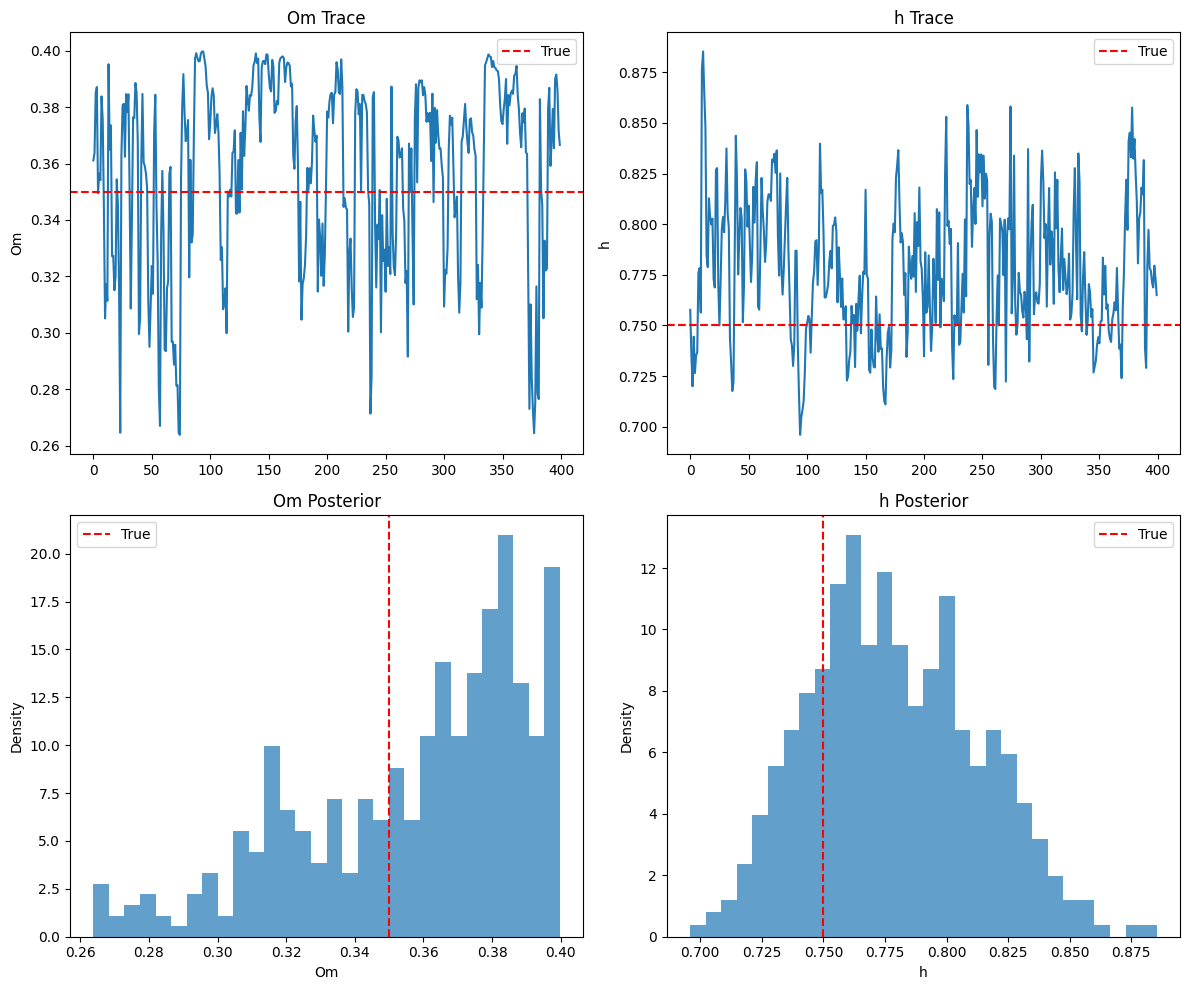

In [6]:
os.makedirs('sci-2-dim-figures', exist_ok=True)
filename = f'sci-2-dim-figures/mcmc_results.png'
plot_mcmc_results(samples, theta_true, save_path=filename)